# Import Libraries

In [1]:
# Common imports
import sys, os
#import sklearn
import numpy as np
import pandas as pd
import pickle
import re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Data Preprocessing and Analysis
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Import dataset from UCIRepo
from ucimlrepo import fetch_ucirepo

In [2]:
# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# Fetch Daya from UCIRepo

#### (i) "Drug reviews"

In [3]:
# Returns dataset "Drug reviews"
drug_review_dataset_drugs_com = fetch_ucirepo(id=462)

# data (as pandas dataframes)
X = drug_review_dataset_drugs_com.data.features
y = drug_review_dataset_drugs_com.data.targets

In [4]:
drug_review_dataset_drugs_com.metadata

{'uci_id': 462,
 'name': 'Drug Reviews (Drugs.com)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com',
 'data_url': 'https://archive.ics.uci.edu/static/public/462/data.csv',
 'abstract': 'The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction.',
 'area': 'Health and Medicine',
 'tasks': ['Classification', 'Regression', 'Clustering'],
 'characteristics': ['Multivariate', 'Text'],
 'num_instances': 215063,
 'num_features': 6,
 'feature_types': ['Integer'],
 'demographics': [],
 'target_col': None,
 'index_col': ['id'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2018,
 'last_updated': 'Wed Apr 03 2024',
 'dataset_doi': '10.24432/C5SK5S',
 'creators': ['Surya Kallumadi', 'Felix Grer'],
 'intro_paper': {'title': 'Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning'

In [5]:
drug_review_dataset_drugs_com.variables

,name,role,type,demographic,description,units,missing_values
0,id,ID,Integer,None,None,None,no
1,drugName,Feature,Categorical,None,None,None,no
2,condition,Feature,Categorical,None,None,None,no
3,review,Feature,Categorical,None,None,None,no
4,rating,Feature,Categorical,None,None,None,no
5,date,Feature,Date,None,None,None,no
6,usefulCount,Feature,Categorical,None,None,None,no


In [6]:
# Instances: n=215,063
# Features: 6

In [7]:
X.shape

(215063, 6)

In [8]:
X.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [9]:
X.review[0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

## Understanding Data

#### Create and Evaluate Vocabulary for the Corpus of the First 5 Reviews

In [11]:
# Get first 5 reviews and remove " if present
text_5 = X.head()['review'].apply(lambda x: x.strip('"').lower())

# char_level=True means text will be tokenized by each character
# char_level=False means tokenize by each word
tokenizer_5 = keras.preprocessing.text.Tokenizer(char_level=False)

tokenizer_5.fit_on_texts(text_5)    # CREATES VOCABULARY

#### Create and Evaluate Vocabulary for the Corpus of All Reviews

In [12]:
text_all = X['review'].apply(lambda x: x.strip('"').lower())
tokenizer_all = keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer_all.fit_on_texts(text_all)  # CREATES VOCABULARY

In [13]:
# word_count prints the number of occurences of each word
# There are 53,635 unique words
len(tokenizer_all.word_counts)

53635

In [14]:
# document_count represents the number of instances/data rows you have
# 215,063 instances
tokenizer_all.document_count

215063

In [15]:
# word_index tell you the token/index value for each word
len(tokenizer_all.word_index)

53635

In [16]:
# What value/token corresponds with had?
tokenizer_all.word_index["had"]

18

In [17]:
# Returns the corresponding index value for its vocabulary stored in tokenizer_all
tokenizer_all.texts_to_sequences(["had"])

[[18]]

In [18]:
# Returns the corresponding word
tokenizer_all.sequences_to_texts([[8, 2, 19, 4, 10, 13]])

['039 and is to was on']

In [19]:
# dict(tokenizer.word_counts)

In [20]:
max_id = len(tokenizer_all.word_index)      # number of distinct words
dataset_size = tokenizer_all.document_count # total number of sentences

In [21]:
# The vocabulary is very big
max_id, dataset_size

(53635, 215063)

# Data Prepreprocessing 
Remove numbers and special characters

### Data Analysis

In [26]:
### max length of reviews
X.review.apply(len).describe()

count    215063.000000
mean        458.316572
std         240.755597
min           3.000000
25%         262.000000
50%         456.000000
75%         690.000000
max       10745.000000
Name: review, dtype: float64

<Axes: >

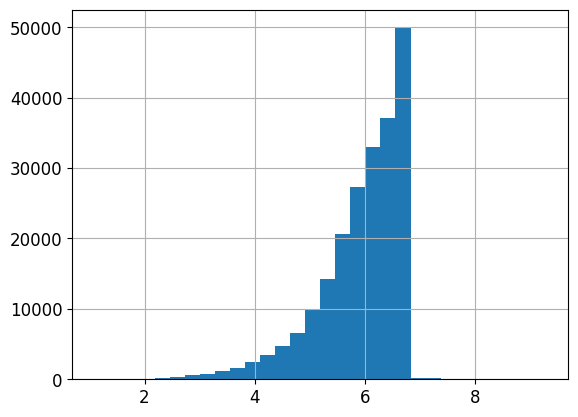

In [27]:
# Plot log of the length of each review to see distribution
X.review.apply(lambda x: np.log(len(x))).hist(bins=30)

In [28]:
np.exp(6), np.exp(6.5), np.exp(7)  # After excluding the tail, the max length of a review is ~1000 chars
### Need to restrict review's length to ~800-1000

(403.4287934927351, 665.1416330443618, 1096.6331584284585)

### Create Toekenzier using Characters

In [23]:
tok = keras.preprocessing.text.Tokenizer(char_level=True) # Tokens are characters!

In [24]:
tok.fit_on_texts(text_all)

In [25]:
tok.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'i': 4,
 'a': 5,
 'o': 6,
 'n': 7,
 's': 8,
 'r': 9,
 'd': 10,
 'h': 11,
 'l': 12,
 'm': 13,
 'c': 14,
 'y': 15,
 'u': 16,
 'g': 17,
 'f': 18,
 'w': 19,
 'p': 20,
 '.': 21,
 'b': 22,
 'v': 23,
 'k': 24,
 ',': 25,
 '0': 26,
 '3': 27,
 ';': 28,
 '&': 29,
 '9': 30,
 '#': 31,
 'x': 32,
 '1': 33,
 '2': 34,
 '!': 35,
 'j': 36,
 'z': 37,
 '5': 38,
 '\n': 39,
 '-': 40,
 'q': 41,
 '4': 42,
 ')': 43,
 '(': 44,
 '6': 45,
 '/': 46,
 '7': 47,
 '8': 48,
 ':': 49,
 '?': 50,
 '%': 51,
 '$': 52,
 '+': 53,
 '*': 54,
 '=': 55,
 '@': 56,
 '~': 57,
 ']': 58,
 '[': 59,
 '`': 60,
 '️': 61,
 '_': 62,
 '\\': 63,
 '❤': 64,
 '^': 65,
 '}': 66,
 '{': 67,
 '\u200b': 68,
 '\t': 69,
 '☺': 70,
 'і': 71,
 '|': 72,
 '♡': 73,
 '،': 74,
 '☹': 75,
 '⭐': 76,
 'ツ': 77,
 '⚠': 78,
 '�': 79,
 '℃': 80,
 '✌': 81,
 '\x11': 82,
 '♀': 83,
 '►': 84,
 '\x7f': 85,
 'ł': 86,
 '℅': 87,
 '✅': 88,
 '̇': 89}

### Clean the Reviews by Only Keeping Alpha Symbols

In [31]:
def keep_alpha_num(text):
    """
    clean up (normalize) the unicode in a raw text
    """
    x = " ".join(map(lambda x: x.strip().lower(), text.split("\n"))).strip()
    x = x.replace("&#039;", " a")  # replace "I'm" by "i am"
    #x = re.sub('[^a-z0-9 ]',' ', x)
    x = re.sub('[^a-z ]',' ', x)   # leaves only letters
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')

    return x

In [32]:
X.review.tail()[-3:]

215060    "I&#039;m married, 34 years old and I have no ...
215061    "I was prescribed Nucynta for severe neck/shou...
215062                                        "It works!!!"
Name: review, dtype: object

In [33]:
X.review.tail()[-3:].apply(keep_alpha_num)

215060     i am married     years old and i have no kids...
215061     i was prescribed nucynta for severe neck shou...
215062                                         it works    
Name: review, dtype: object

In [34]:
### Pre-process and check characters again

In [35]:
X['review_clean'] = X['review'].apply(keep_alpha_num)
tokenizer_clean = keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer_clean.fit_on_texts(X['review_clean'])

In [36]:
tokenizer_clean.texts_to_sequences(["had"])

[[18]]

In [37]:
tokenizer_clean.sequences_to_texts([[8, 2, 19, 4, 10, 13]])

['for and am to have on']

In [38]:
max_id = len(tokenizer_clean.word_index)      # number of distinct "words"
dataset_size = tokenizer_clean.document_count # total number of sentences

In [39]:
max_id, dataset_size  # still a large vocabulary but it's clean - see below

(50071, 215063)

In [40]:
tok_clean = keras.preprocessing.text.Tokenizer(char_level=True)
tok_clean.fit_on_texts(X['review_clean'])

In [41]:
tok_clean.word_index.keys()

dict_keys([' ', 'e', 't', 'a', 'i', 'o', 'n', 's', 'r', 'd', 'h', 'l', 'm', 'c', 'y', 'u', 'g', 'f', 'w', 'p', 'b', 'v', 'k', 'x', 'j', 'z', 'q'])

### Understanding Distribution of Labels (Rating Numbers)

In [42]:
Xc = X.rating.value_counts()

In [43]:
Xc.sort_index()

rating
1     28918
2      9265
3      8718
4      6671
5     10723
6      8462
7     12547
8     25046
9     36708
10    68005
Name: count, dtype: int64

Text(0, 0.5, 'Rating frequency')

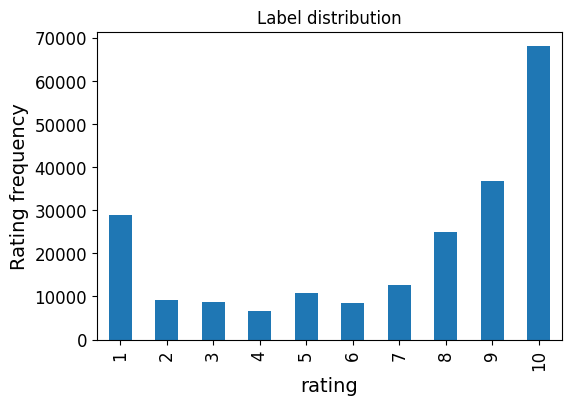

In [44]:
temp = Xc.sort_index()
plt.figure(figsize=(6,4))
temp.plot(kind='bar', title='Label distribution')
plt.ylabel('Rating frequency')

In [45]:
#### Binarize the label to "positive" (=1) and "negative" (=0, when rating <=5)
X['label']= X.rating.apply(lambda x: 1 if x>5 else 0)

In [46]:
X.label.value_counts()

label
1    150768
0     64295
Name: count, dtype: int64

In [47]:
# Drug frequency & sentiment
X.drugName.value_counts().sort_values()

drugName
Allergy DN PE                           1
Aspirin / meprobamate                   1
Xodol                                   1
Noritate                                1
Benzoyl peroxide / salicylic acid       1
                                     ... 
Ethinyl estradiol / norgestimate     2790
Nexplanon                            2892
Ethinyl estradiol / norethindrone    3753
Etonogestrel                         4421
Levonorgestrel                       4930
Name: count, Length: 3671, dtype: int64

In [48]:
pd.crosstab(X.drugName, X.label)

label,0,1
drugName,,
A + D Cracked Skin Relief,0,1
A / B Otic,0,2
Abacavir / dolutegravir / lamivudine,13,57
Abacavir / lamivudine,0,3
Abacavir / lamivudine / zidovudine,0,1
...,...,...
ZzzQuil,3,0
depo-subQ provera 104,1,1
ella,20,51


# Split Data into Train, Validation, and Test

In [50]:
X['review_clean'].shape, X['label'].shape

((215063,), (215063,))

In [51]:
X_tr, X_test, y_tr, y_test = train_test_split(X['review_clean'],X['label'],test_size=0.1,random_state=42)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tr,y_tr,test_size=0.15,random_state=42)

In [53]:
X_tr.shape, y_tr.shape

((193556,), (193556,))

In [54]:
y_test

14311     1
72301     0
23041     1
197721    1
133612    1
         ..
190160    1
77024     1
105893    1
44790     0
4093      1
Name: label, Length: 21507, dtype: int64

In [56]:
tf.constant(X_train.to_numpy())[1]

<tf.Tensor: shape=(), dtype=string, numpy=b' cleared up the uti but   weeks after taking the final tablet i am still having side effects   first noticed that i had a sore throat and stiff neck after taking tablets for   days   was given a seven day course  but did not make connection with taking antibiotics  continued to take medication   i then developed sensitive scalp  neck pain got worse and on and off headaches plus shoulder back pain   felt awful   i was on holiday at the time and it seemed to ease after about a week   reported to my gp on returning to the uk   now   weeks later  on holidays again  neck pain  sore skin  head pains are all back  hope this helps others   not sure if i should seek medical attention or just hope problems go with time  '>

In [57]:
X_train

184104     i ave been suffering from      muscle pain  c...
129711     cleared up the uti but   weeks after taking t...
153238     this is the most amazing thing ever  it burns...
187172     i am a    yr old male and have been smoking f...
93508      this is my second week of taking fluoxetine a...
                                ...                        
193541     amlodipine   mg is helping to lower my blood ...
34863      i am now in my third month of using minastrin...
100945     indomethacin really works good for me  i got ...
189494     this medication is good   feel so good that i...
189201     chantix worked for me  i tried to quit many t...
Name: review_clean, Length: 164522, dtype: object

# Train Model

### Create tensors and train the model

In [58]:
raw_train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
raw_test_set  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [59]:
tf.random.set_seed(42)

train_set_2 = raw_train_set.shuffle(5000, seed=42).batch(256).prefetch(1)
valid_set_2 = raw_valid_set.batch(256).prefetch(1)
test_set_2 = raw_test_set.batch(256).prefetch(1)

In [60]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set_2.map(lambda reviews, labels: reviews))

In [61]:
len(text_vec_layer.get_vocabulary())

1000

## Model 1 - 2 GRUs, 1 Dense Layer, and 50% Dropout

I chose a more complicated and deep architecture because I didn't think the model would learn the data well. I added 50% dropout to make sure that there was regularization so that it could counteract the chance of overfitting. The downside of training this model was that it was long to train and I still got overfitting, but in 14 epochs, I did get an accuracy of 94.7%.

In [73]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=True),  # Return sequences for deeper layers
    tf.keras.layers.GRU(128),  # Second GRU layer
    tf.keras.layers.Dense(64, activation="relu"),  # Add a dense layer
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="Adam",
              metrics=["accuracy"])

In [74]:
history = model.fit(train_set_2, validation_data=valid_set_2, epochs=50, callbacks=[early_stopping])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3008s 5s/step - accuracy: 0.7736 - loss: 0.4822 - val_accuracy: 0.8374 - val_loss: 0.3682
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2264s 4s/step - accuracy: 0.8410 - loss: 0.3658 - val_accuracy: 0.8500 - val_loss: 0.3349
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1799s 3s/step - accuracy: 0.8569 - loss: 0.3316 - val_accuracy: 0.8592 - val_loss: 0.3212
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2269s 4s/step - accuracy: 0.8665 - loss: 0.3091 - val_accuracy: 0.8678 - val_loss: 0.3062
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1931s 3s/step - accuracy: 0.8773 - loss: 0.2861 - val_accuracy: 0.8714 - val_loss: 0.2982
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1959s 3s/step - accuracy: 0.8837 - loss: 0.2704 - val_accuracy: 0.8760 - val_loss: 0.2945
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1978s 3s/step - accuracy: 0.8903 - loss: 0.2563 - val_accuracy: 0.8804 - val_loss: 0.2854
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2087s 3s/step - accuracy: 0.8983 - loss: 0.2398 - 

In [108]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 128)           │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, None, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,003,397 (3.83 MB)

 Trainable params: 334,465 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,932 (2.55 MB)

## Model 2 -Simple GRU Arhcitecture
Since the first model had a decent amount of overfitting towards the end of training, I wanted to see what a simple GRU model could produce. It was much better for training because it took signifcantly less time to train. Not only that, but I was able to achieve 93.4% accuracy in just 13 epochs proving to me that the first model had too many layers that did not signifcantly improve the performance. Unfortunately, there was still overfitting.

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

embed_size = 128

tf.random.set_seed(42)
model2 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=False),  # No need to return sequences here
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model2.compile(loss="binary_crossentropy", optimizer="Adam",
              metrics=["accuracy"])


In [118]:
history2 = model2.fit(train_set_2, validation_data=valid_set_2, epochs=50, callbacks=[early_stopping])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3503s 5s/step - accuracy: 0.7715 - loss: 0.4807 - val_accuracy: 0.8383 - val_loss: 0.3718
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4577s 7s/step - accuracy: 0.8387 - loss: 0.3647 - val_accuracy: 0.8458 - val_loss: 0.3477
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1078s 2s/step - accuracy: 0.8521 - loss: 0.3372 - val_accuracy: 0.8524 - val_loss: 0.3316
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1079s 2s/step - accuracy: 0.8600 - loss: 0.3180 - val_accuracy: 0.8561 - val_loss: 0.3314
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1184s 2s/step - accuracy: 0.8684 - loss: 0.2994 - val_accuracy: 0.8651 - val_loss: 0.3084
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.8768 - loss: 0.2839 - val_accuracy: 0.8682 - val_loss: 0.3056
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.8855 - loss: 0.2668 - val_accuracy: 0.8749 - val_loss: 0.2951
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1200s 2s/step - accuracy: 0.8936 - loss: 0.2511 - 

In [111]:
model2.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_15 (Embedding)             │ (None, None, 128)           │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_20 (GRU)                         │ (None, None, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, None, 1)             │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227,201 (887.50 KB)

 Trainable params: 227,201 (887.50 KB)

 Non-trainable params: 0 (0.00 B)

## Model 3 - Simple Long Short Term Memory (LSTM) Architecture

Since I knew the GRU simple model was a pretty effective model with some overfitting in the later epochs, I wanted to see if a simple LSTM model would be better. I am still not sure why model 3 early stopped in 3 epochs since the validation loss decreased with every epoch, but I was pretty convinced that it would be better to use than a GRU. In 3 epochs, it was significantly faster to train.

In [119]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

embed_size = 128

tf.random.set_seed(42)
model3 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.LSTM(128),  # Switched to LSTM layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model3.compile(loss="binary_crossentropy", optimizer="Adam",
               metrics=["accuracy"])


In [120]:
history3 = model3.fit(train_set_2, validation_data=valid_set_2, epochs=50, callbacks=[early_stopping])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.7760 - loss: 0.4748 - val_accuracy: 0.8210 - val_loss: 0.3999
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1102s 2s/step - accuracy: 0.8329 - loss: 0.3815 - val_accuracy: 0.8371 - val_loss: 0.3700
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1116s 2s/step - accuracy: 0.8489 - loss: 0.3472 - val_accuracy: 0.8499 - val_loss: 0.3375


In [ ]:
model3.summary()

## Model 4 - 1 LSTM, 2 Dense Layers, 30% Dropout
Before training model 3 again, I wanted to see how the model would perform with two extra dense layers and regularization to help out with the overfitting. I had another weird situation where the model stopped early even though the validation loss decreased with every epoch.

In [135]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

embed_size = 128

tf.random.set_seed(42)
model4 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.LSTM(128),  # Switched to LSTM layer
    tf.keras.layers.Dense(128, activation="sigmoid"),
    tf.keras.layers.Dropout(0.3),  # Add dropout for regularization
    tf.keras.layers.Dense(32, activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model4.compile(loss="binary_crossentropy", optimizer="Adam",
               metrics=["accuracy"])


In [136]:
history4 = model4.fit(train_set_2, validation_data=valid_set_2, epochs=50, callbacks=[early_stopping])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1201s 2s/step - accuracy: 0.7250 - loss: 0.5442 - val_accuracy: 0.8240 - val_loss: 0.3979
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1211s 2s/step - accuracy: 0.8274 - loss: 0.3906 - val_accuracy: 0.8368 - val_loss: 0.3738
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1248s 2s/step - accuracy: 0.8418 - loss: 0.3625 - val_accuracy: 0.8484 - val_loss: 0.3422


In [137]:
model4.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_23 (Embedding)             │ (None, None, 128)           │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 840,773 (3.21 MB)

 Trainable params: 280,257 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 560,516 (2.14 MB)

## Model 5 - Simple LSTM Model

When I ran the model 3 architecture again, the model ran well. Unfortunately, my computer turned off during training so I was not able to train fully, but the model would probably have stopped in the next few epochs since the accuracy was decreasing less with each epoch. There was a little overfitting starting around 8 epochs, but it was not bad.

In [138]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

embed_size = 128

tf.random.set_seed(42)
model5 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.LSTM(128),  
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model5.compile(loss="binary_crossentropy", optimizer="Adam",
               metrics=["accuracy"])


In [ ]:
history5 = model5.fit(train_set_2, validation_data=valid_set_2, epochs=50, callbacks=[early_stopping])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1515s 2s/step - accuracy: 0.7765 - loss: 0.4768 - val_accuracy: 0.8291 - val_loss: 0.3851
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1349s 2s/step - accuracy: 0.8344 - loss: 0.3786 - val_accuracy: 0.8403 - val_loss: 0.3582
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1350s 2s/step - accuracy: 0.8498 - loss: 0.3438 - val_accuracy: 0.8508 - val_loss: 0.3410
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.8630 - loss: 0.3181 - val_accuracy: 0.8603 - val_loss: 0.3218
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1882s 3s/step - accuracy: 0.8726 - loss: 0.2977 - val_accuracy: 0.8678 - val_loss: 0.3097
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1122s 2s/step - accuracy: 0.8809 - loss: 0.2827 - val_accuracy: 0.8709 - val_loss: 0.3040
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1150s 2s/step - accuracy: 0.8878 - loss: 0.2674 - val_accuracy: 0.8723 - val_loss: 0.3126
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1460s 2s/step - accuracy: 0.8954 - loss: 0.2535 - 

In [ ]:
model5.summary()

## Train with Model5 Architecture but Changing the Batch Size
I wanted to see if the training would change if I changed the batch size. I quickly realized that a batch size of 32 was a great batch size since it was faster to train and I got an accuracy of 93.2% in 8 epochs.

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1)
embed_size = 128
batch_sizes = [32, 64, 128, 256, 512]

# Define model architecture
tf.random.set_seed(42)
model_batch = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_batch.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Train models with different batch sizes
histories = []
for batch_size in batch_sizes:
    train_set_batched = raw_train_set.shuffle(5000, seed=42).batch(batch_size).prefetch(1)
    valid_set_batched = raw_valid_set.batch(batch_size).prefetch(1)
    history = model_batch.fit(train_set_batched, validation_data=valid_set_batched, epochs=10, callbacks=[early_stopping])
    histories.append(history)

Epoch 1/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 1261s 244ms/step - accuracy: 0.7950 - loss: 0.4468 - val_accuracy: 0.8446 - val_loss: 0.3562
Epoch 2/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 1261s 245ms/step - accuracy: 0.8485 - loss: 0.3448 - val_accuracy: 0.8589 - val_loss: 0.3238
Epoch 3/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 1258s 245ms/step - accuracy: 0.8657 - loss: 0.3107 - val_accuracy: 0.8712 - val_loss: 0.3010
Epoch 4/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 1286s 250ms/step - accuracy: 0.8812 - loss: 0.2776 - val_accuracy: 0.8786 - val_loss: 0.2911
Epoch 5/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 859s 167ms/step - accuracy: 0.8949 - loss: 0.2519 - val_accuracy: 0.8796 - val_loss: 0.2867
Epoch 6/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 731s 142ms/step - accuracy: 0.9078 - loss: 0.2223 - val_accuracy: 0.8872 - val_loss: 0.2847
Epoch 7/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 746s 145ms/step - accuracy: 0.9212 - loss: 0.1950 - val_accuracy: 0.8931 - val_loss: 0.2770
Epoch 8/10
5142/5142 ━━━━━━━━━━━━━━━━━━━━ 757s 147ms/step 

KeyboardInterrupt: 

# Model6 with Model4 Architecture
Knowing that each model experiences overfitting by around the eighth epoch, I knew I had to include some regularization in the LSTM model so I used the architecture of model 4. With this, I trained my final model with a batch size of 16 since the smaller batch size performed better. Unfortunately, my computer died during training but by far it performed the best because, in 9 epochs, I achieved a 94.3% accuracy. This is very comparable to the accuracy of the first model but with fewer parameters and faster training time. I would recommend this model to best train the data but I think all of these models are sufficient enough to model the data. 

In [66]:
train_set_32 = raw_train_set.shuffle(5000, seed=42).batch(16).prefetch(1)
valid_set_32 = raw_valid_set.batch(16).prefetch(1)
test_set_32 = raw_test_set.batch(16).prefetch(1)

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

embed_size = 128

tf.random.set_seed(42)
model6 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.LSTM(128),  # Switched to LSTM layer
    tf.keras.layers.Dense(64, activation="sigmoid"),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(16, activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model6.compile(loss="binary_crossentropy", optimizer="Adam",
               metrics=["accuracy"])

In [ ]:
history6 = model6.fit(train_set_32, validation_data=valid_set_32, epochs=10, callbacks=[early_stopping])

Epoch 1/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 1079s 105ms/step - accuracy: 0.7718 - loss: 0.4858 - val_accuracy: 0.8454 - val_loss: 0.3509
Epoch 2/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 1192s 116ms/step - accuracy: 0.8490 - loss: 0.3442 - val_accuracy: 0.8628 - val_loss: 0.3195
Epoch 3/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 1137s 111ms/step - accuracy: 0.8705 - loss: 0.3018 - val_accuracy: 0.8715 - val_loss: 0.2997
Epoch 4/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 1185s 115ms/step - accuracy: 0.8840 - loss: 0.2703 - val_accuracy: 0.8769 - val_loss: 0.2953
Epoch 5/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 1121s 109ms/step - accuracy: 0.8963 - loss: 0.2441 - val_accuracy: 0.8817 - val_loss: 0.2951
Epoch 6/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 2756s 268ms/step - accuracy: 0.9119 - loss: 0.2149 - val_accuracy: 0.8906 - val_loss: 0.2870
Epoch 7/10
10283/10283 ━━━━━━━━━━━━━━━━━━━━ 2105s 205ms/step - accuracy: 0.9240 - loss: 0.1897 - val_accuracy: 0.8949 - val_loss: 0.2944
Epoch 8/10
10283/10283 ━━━━━━━━━━━━━━━━━━